In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
fake = pd.read_csv('/content/gdrive/My Drive/Fake.csv')
real = pd.read_csv('/content/gdrive/My Drive/True.csv')

In [5]:
fake.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [6]:
real.subject.unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [7]:
fake.drop(['subject', 'date'], axis=1, inplace=True)
real.drop(['subject', 'date'], axis=1, inplace=True)

In [8]:
fake['class'] = 0
real['class'] = 1

Text(0, 0.5, 'Proportion of News Articles')

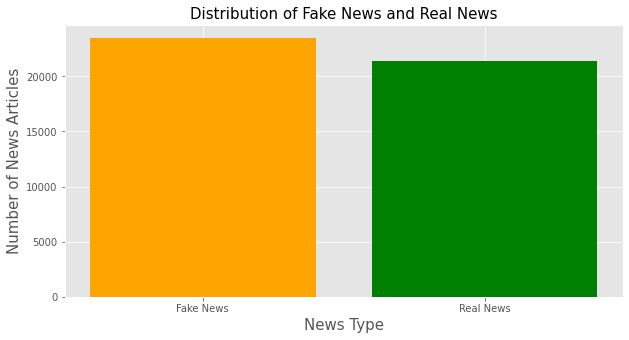

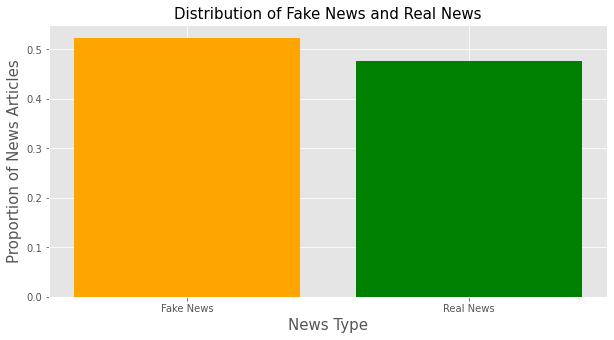

In [9]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake), color='orange')
plt.bar('Real News', len(real), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Number of News Articles', size=15)


total_len = len(fake) + len(real)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake) / total_len, color='orange')
plt.bar('Real News', len(real) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [10]:
df = pd.concat([real, fake], ignore_index=True, sort=False)
df

,title,text,class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0


In [12]:
df['text'] = df['title'] + df['text']
df.drop('title', axis=1, inplace=True)

In [13]:
features = df['text']
targets = df['class']

x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

In [14]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        i = re.sub('https?://\S+|www\.\S+', '', i)
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

x_train = normalize(x_train)
x_test = normalize(x_test)

In [15]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train)

In [16]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [17]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=256)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen=256)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         49664     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
________________________________________________

In [22]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 411s 375ms/step - loss: 0.4340 - accuracy: 0.7470 - val_loss: 0.0755 - val_accuracy: 0.9788
Epoch 2/10
1078/1078 [==============================] - 406s 376ms/step - loss: 0.0599 - accuracy: 0.9846 - val_loss: 0.0593 - val_accuracy: 0.9833
Epoch 3/10
1078/1078 [==============================] - 405s 376ms/step - loss: 0.0327 - accuracy: 0.9921 - val_loss: 0.0378 - val_accuracy: 0.9869
Epoch 4/10
1078/1078 [==============================] - 409s 379ms/step - loss: 0.0213 - accuracy: 0.9953 - val_loss: 0.0416 - val_accuracy: 0.9875
Epoch 5/10
1078/1078 [==============================] - 410s 381ms/step - loss: 0.0163 - accuracy: 0.9965 - val_loss: 0.0412 - val_accuracy: 0.9905


In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
pred = model.predict(x_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
print('Testing set accuracy:', accuracy_score(binary_predictions, y_test))
print('Testing set precision:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)